In [9]:
import qtensor
import numpy as np
import torch

from circuit_11 import circuit_11, get_circ_and_peo

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
N = 8
FIXED = 4
LAYERS = 3

## Read eignestates

In [12]:
from pathlib import Path
def read_eigenstate(L=8, delta=0):
    data_path = Path(f'../data/XXZ_L{L}/')
    filename = f'XXZwave_{L}_{delta}.npy'
    return np.load(data_path/filename)

In [13]:
read_eigenstate(L=N).shape

(256, 1)

In [14]:
import qtree
class InitSim(qtensor.QtreeSimulator):
    def set_init_state(self, state):
        self.init_state = state

    def _create_buckets(self):
        self.tn = qtensor.optimisation.QtreeTensorNet.from_qtree_gates(
            self.all_gates, init_state=self.init_state, backend=self.backend,
        )
        self.tn.backend = self.backend

    def _get_slice_dict(self, initial_state=0, target_state=0):
        slice_dict = {}
        slice_dict.update(qtree.utils.slice_from_bits(target_state, self.tn.bra_vars))
        slice_dict.update(qtree.utils.slice_from_bits(target_state, self.tn.bra_vars))
        slice_dict.update({var: slice(None) for var in self.tn.free_vars})
        slice_dict.update({var: slice(None) for var in self.tn.ket_vars})
        return slice_dict

In [15]:
sim = InitSim(backend=qtensor.contraction_backends.get_backend('torch'))

In [20]:
data_size = 100
data_x = [
    read_eigenstate(L=N, delta=i) for i in range(data_size)
]
data_y = range(data_size)
data = list(zip(data_x, data_y))
train_size = 30
test_size = data_size - train_size
train_set, test_set = torch.utils.data.random_split(data, [train_size, test_size])

In [21]:
print(len(list(train_set)))

30


In [22]:
def amps2loss(amps):
    return -torch.abs(amps*torch.conj(amps)).sum()

In [23]:
def get_loss(sim, train_set):
    loss = torch.tensor(0.)
    for train_x, train_y in train_set:
        sim.set_init_state(train_x)
        amps = sim.simulate_batch(circ, peo=peo, batch_vars=range(FIXED, N))
        l = amps2loss(amps)
        loss += l
    loss /= len(train_set)
    return loss

In [24]:
parameters = torch.rand(LAYERS*(4*N - 4), requires_grad=True)
parameters.retain_grad()
parameters

tensor([0.7277, 0.0107, 0.2779, 0.5104, 0.8880, 0.8479, 0.6056, 0.3792, 0.3603,
        0.4021, 0.9668, 0.7918, 0.3956, 0.6102, 0.8354, 0.0720, 0.8198, 0.4500,
        0.6555, 0.6692, 0.1936, 0.7529, 0.7618, 0.7165, 0.9381, 0.4109, 0.7535,
        0.5103, 0.3184, 0.2534, 0.2606, 0.7289, 0.5116, 0.9192, 0.1318, 0.0244,
        0.0694, 0.3260, 0.6682, 0.5736, 0.6656, 0.2070, 0.6280, 0.0393, 0.0831,
        0.6461, 0.4826, 0.3920, 0.7455, 0.3924, 0.3594, 0.9548, 0.7079, 0.1842,
        0.3481, 0.3769, 0.7517, 0.8305, 0.9391, 0.3924, 0.7449, 0.0461, 0.6896,
        0.7983, 0.7193, 0.0863, 0.1668, 0.4606, 0.4169, 0.9816, 0.8211, 0.7066,
        0.9947, 0.0600, 0.5449, 0.2000, 0.8357, 0.2274, 0.7555, 0.2220, 0.6767,
        0.4526, 0.9764, 0.0826], requires_grad=True)

In [25]:
lr = 0.05

In [26]:
optimizer = torch.optim.Adam([parameters], lr=lr)

In [27]:
steps = 150
stop_epsilon = 1e-4

In [28]:
loss_prev = np.inf

peo, circ = get_circ_and_peo(parameters, N=N, layers=LAYERS, fixed=FIXED)
for i in range(steps):
    
    loss = get_loss(sim, train_set)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'[{i}] loss=', loss.data, 'sum_grad=', np.abs(parameters.grad.detach().numpy().sum()))
    
    if abs((loss_prev - loss.data.numpy())/loss.data) < stop_epsilon:
        print(f'Reached convergence after {i} steps!')
        break
    #print(amps.data, np.abs(np.square(amps.detach().numpy())))
    loss_prev = loss.data
    parameters.grad.zero_()
    

/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[0] loss= tensor(-0.1413) sum_grad= 0.51794136
[1] loss= tensor(-0.3107) sum_grad= 0.87720126
[2] loss= tensor(-0.3989) sum_grad= 1.440692
[3] loss= tensor(-0.4841) sum_grad= 0.4295811
[4] loss= tensor(-0.4950) sum_grad= 0.95724267
[5] loss= tensor(-0.5356) sum_grad= 0.85631335
[6] loss= tensor(-0.5956) sum_grad= 0.588262
[7] loss= tensor(-0.6100) sum_grad= 0.23329653
[8] loss= tensor(-0.6046) sum_grad= 0.3869309
[9] loss= tensor(-0.6228) sum_grad= 1.0131328
[10] loss= tensor(-0.6592) sum_grad= 1.080483
[11] loss= tensor(-0.6919) sum_grad= 0.45782313
[12] loss= tensor(-0.6955) sum_grad= 0.18208109
[13] loss= tensor(-0.6971) sum_grad= 0.31562105
[14] loss= tensor(-0.7044) sum_grad= 0.20588411
[15] loss= tensor(-0.7109) sum_grad= 0.22333531
[16] loss= tensor(-0.7080) sum_grad= 0.31487283
[17] loss= tensor(-0.7178) sum_grad= 0.22719817
[18] loss= tensor(-0.7283) sum_grad= 0.08125567


KeyboardInterrupt: 

In [29]:
len(parameters)/3

28.0

## Test results

In [30]:
import matplotlib.pyplot as plt


In [31]:
def get_compression(delta):
    """
    Returns:
        original_state, compressed_state
    """
    test_sim = InitSim()
    #test_sim = qtensor.QtreeSimulator()
    state = read_eigenstate(L=N, delta=delta)
    test_sim.set_init_state(state)
    params = parameters.detach().numpy()
    peo, circ = get_circ_and_peo(parameters.detach().numpy(), N=N,
                                 layers=LAYERS, fixed=0, backend='numpy',
                                )
    amps_np = test_sim.simulate_batch(circ, peo=peo, batch_vars=N)
    return state.flatten(), amps_np
    

In [32]:
def compare_compression(orig_state, compressed_state):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plt.sca(axs[0])
    plot_state(orig_state)
    plt.sca(axs[1])
    plot_state(compressed_state)
    

In [122]:
import matplotlib as mpl

def get_color(index, length):
    _cmap = mpl.cm.get_cmap('gnuplot2')
    _c_value = index/(length - 1)
    # Do not include edges
    _edge_shift = .24
    _c_value = _c_value*(1 - 2*_edge_shift) + _edge_shift
    return _cmap(_c_value)

In [137]:
def plot_state(state, higlight_first=16):
    probs = np.abs(state*state).flatten()
    plt.bar(range(len(probs)), probs,
            color=[get_color(1, 2)]*higlight_first+[get_color(0, 2)]*(len(probs)-higlight_first)
           )

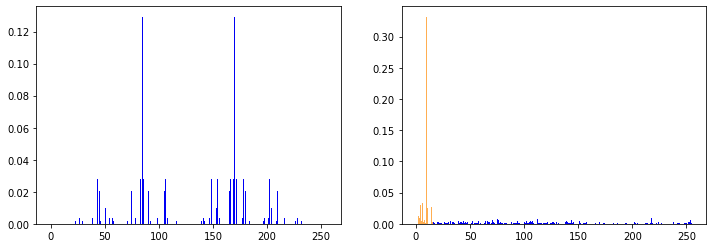

In [138]:
compression = get_compression(delta=10)
compare_compression(*compression)
plt.savefig('../data/figures/compression_statevector_comparison.pdf')

### Look at more test

In [32]:
compressions = [get_compression(delta=i) for i in range(len(train_set))[:5]]    

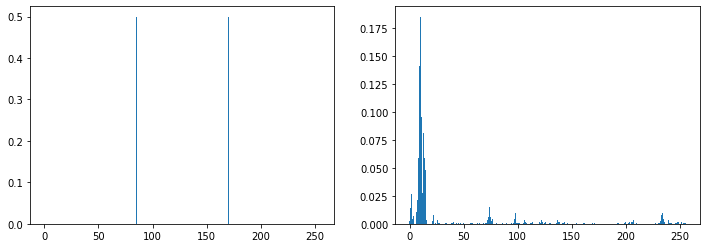

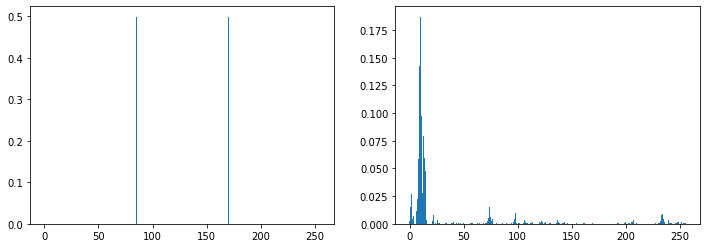

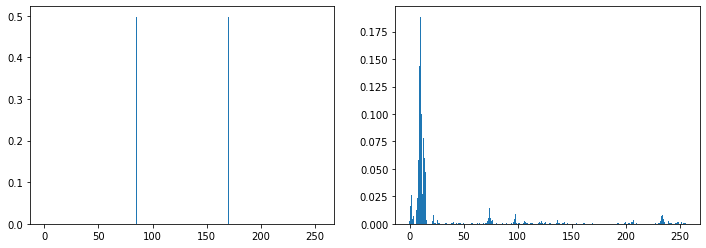

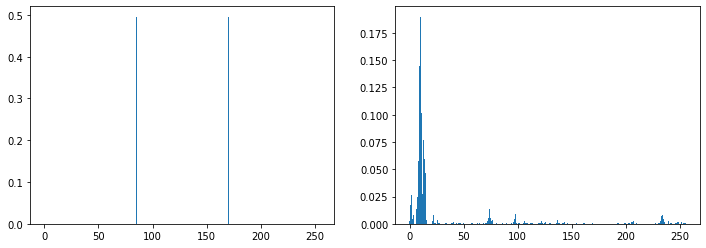

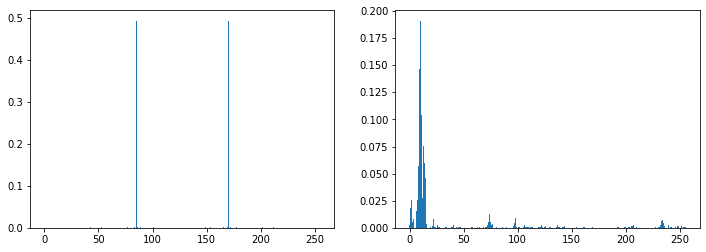

In [33]:
_ = [compare_compression(*i) for i in compressions]

In [ ]:
compressed

## Plot fidelity susceptibility

In [96]:
from cartesian_explorer import Explorer
from cartesian_explorer.caches import JobLibCache
cache = JobLibCache('../data/caex_cache/fsup')
ex = Explorer(cache=cache)

In [97]:
deltas = np.linspace(0.5, 3, 100)

In [98]:
@ex.provider
def eigenstate(L, index):
    delta =  np.where(deltas==index)[0].flatten()[0]
    data_path = Path(f'../data/XXZ_L{L}/')
    filename = f'XXZwave_{L}_{delta}.npy'
    return np.load(data_path/filename).flatten()

@ex.provider
def eigenstate_delta(L, index):
    delta =  np.where(deltas==index)[0].flatten()[0]
    data_path = Path(f'../data/XXZ_L{L}/')
    filename = f'XXZwavedeltadelta_{L}_{delta}.npy'
    return np.load(data_path/filename).flatten()

In [99]:
def encode_state(state, parameters):
    test_sim = InitSim()
    #test_sim = qtensor.QtreeSimulator()
    test_sim.set_init_state(state)
    peo, circ = get_circ_and_peo(parameters, N=N,
                                 layers=LAYERS, fixed=0, backend='numpy',
                                )
    amps_np = test_sim.simulate_batch(circ, peo=peo, batch_vars=N)
    return amps_np


In [100]:
@ex.provider
def encoded(eigenstate, parameters):
    return encode_state(eigenstate, parameters)
    
@ex.provider
def encoded_delta(eigenstate_delta, parameters):
    return encode_state(eigenstate_delta, parameters)
    

In [101]:
def fsup(a,b,deltadelta=0.001):
    return 2*(1-np.abs(np.dot(a.conj(),b))**2)/(N*deltadelta**2)
              
@ex.provider
def fsup_original(eigenstate, eigenstate_delta):
    return fsup(eigenstate, eigenstate_delta)
    
@ex.provider
def fsup_encoded(encoded, encoded_delta):
    return fsup(encoded, encoded_delta)

@ex.provider
def fsup_encoded_traced(encoded, encoded_delta):
    pseudo_trace = lambda x: x.reshape(*[2]*N).sum(axis=tuple(range(FIXED))).flatten()
    a, b = pseudo_trace(encoded), pseudo_trace(encoded_delta)
    return fsup(a, b)

@ex.provider
def fsup_encoded_sliced(encoded, encoded_delta):
    a, b = encoded[:2**FIXED], encoded_delta[:2**FIXED]
    return fsup(a, b)

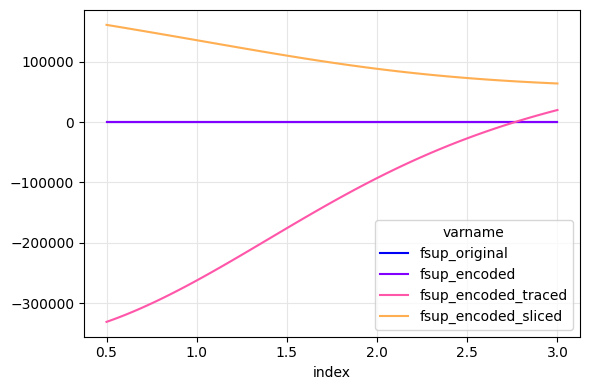

In [102]:
fig = ex.plot_variables(('fsup_original', 'fsup_encoded', 'fsup_encoded_traced', 'fsup_encoded_sliced'),
                        L=[8],
                        index=np.linspace(0.5, 3, 100),
                        parameters=[parameters.detach().numpy()]
                 ),

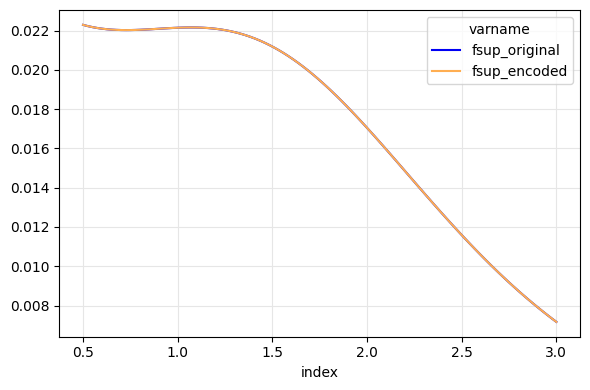

In [103]:
fig = ex.plot_variables(('fsup_original', 'fsup_encoded'),
                        L=[8],
                        index=np.linspace(0.5, 3, 100),
                        parameters=[parameters.detach().numpy()]
                 ),

In [6]:
from collections import defaultdict

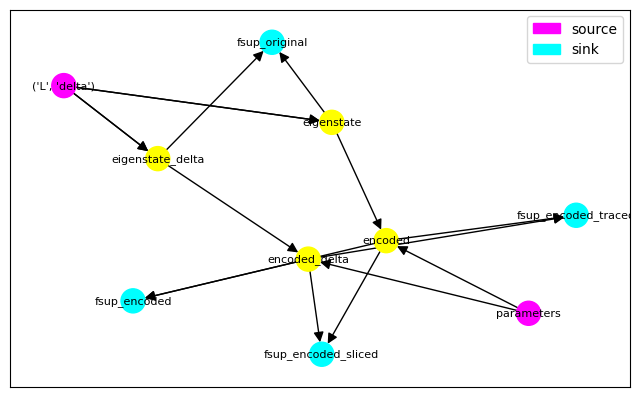

In [8]:
fig = ex.draw_dependency_graph(edge_labels=defaultdict(lambda x: ''))

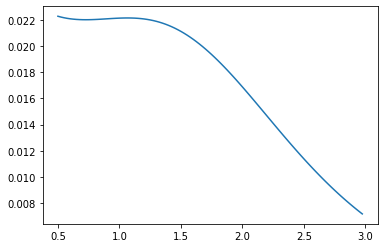

In [94]:
y_ = np.load('../data/yaxis_fidelity_L_8.npy')
x_ = np.load('../data/xaxis_delta.npy')
plt.plot(x_, y_)

In [ ]:
[
    wave_0,
    wave_1
]